Applying 1st and Higher Order Markov Chains
## LA Lakers Game Stats

Name:
Date:


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

### function needed

In [ ]:
# function to pick between two states, given their mutual probabilities

def pick_state(var_a, prob_a, var_b, prob_b):

    # Validate input probabilities
    if not (0 <= prob_a <= 1 and 0 <= prob_b <= 1):
        raise ValueError("Input probabilities must be between 0 and 1")

    # Calculate the cumulative probabilities
    cum_prob_a = prob_a
    cum_prob_b = prob_a + prob_b

    # Generate a random number between 0 and 1
    rand = random.random()

    # Determine which character to pick based on the random number
    if rand < cum_prob_a:
        return var_a
    elif rand < cum_prob_b:
        return var_b
    else:
        raise Exception("Unexpected error: random number outside [0, 1]")


In [ ]:
# test function with sample input values. Run this cell multiple times, you should see both A and B appearing

pick_state('A', 0.3, 'B', 0.7)

'A'

In [ ]:
# function to get all sequences (even overlapping) of length n in a given string named 'sequence'

def get_n_letter_sequences(sequence, n):

    return [sequence[i:i+n] for i in range(len(sequence) - n + 1)]


In [ ]:
# test function with sample string

get_n_letter_sequences('ABBBBABABA', 3)

['ABB', 'BBB', 'BBB', 'BBA', 'BAB', 'ABA', 'BAB', 'ABA']

## read data into dataframe

In [ ]:
# df_LAL.to_csv('LALakers_21-23.csv')


In [ ]:
df_LAL = pd.read_csv('LALakers_21-23.csv')
# df_LAL

## 1st order Markov Chain

### training and test data

In [ ]:
# train only on 2021-22 first half

seq_train = ''.join(df_LAL.loc[df_LAL.season=='21-22'][:40]['result'].values)
seq_train

'LLWWLWWWLLWWLWLLLWLWLWWLWLWWWLLLLLWLWWWW'

In [ ]:
# get test data - second half of 21-22 season

seq_test = df_LAL.loc[df_LAL.season=='21-22'][40:]['result'].values
seq_test

array(['L', 'L', 'L', 'W', 'L', 'W', 'L', 'W', 'L', 'L', 'L', 'W', 'L',
       'W', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'W',
       'L', 'L', 'L', 'W', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'W', 'W'], dtype=object)

### generate transition matrix of order-1 Markov

In [ ]:

# get all sequences of length 1 in the training data
seq_1_list        = np.array(get_n_letter_sequences(seq_train, 1))
unique_seq_1_list = np.sort(np.unique(seq_1_list))

# get all sequences of length 2 in the training data
seq_1plus1_list        = np.array(get_n_letter_sequences(seq_train, 2))
unique_seq_1plus1_list = np.sort(np.unique(seq_1plus1_list))

# create an empty matrix that will eventually hold the transition probabilities
arr_tr_mat = np.zeros((2, unique_seq_1_list.shape[0]))

print ('seq-o' + str(1), '\tseq-o' + str(1+1), '\tcount', '\tprob_of_seq-o' + str(1+1))

for i, seq_n in enumerate(unique_seq_1_list):

    # possible next states appended to seq_n. There are only two possibilities
    seq_1plus1_0 = seq_n + 'L'
    seq_1plus1_1 = seq_n + 'W'

    # Count all occurrences of the above sequences in all the n+1 length sequences
    count_seq_1plus1_0 = (seq_1plus1_list == seq_1plus1_0).sum()
    count_seq_1plus1_1 = (seq_1plus1_list == seq_1plus1_1).sum()

    # get ratios of occurrences of each n+1 length sequence
    prob_seq_1plus1_0 = count_seq_1plus1_0/(count_seq_1plus1_0+count_seq_1plus1_1)
    prob_seq_1plus1_1 = count_seq_1plus1_1/(count_seq_1plus1_0+count_seq_1plus1_1)

    # to see the output
    print (seq_n, '\t', seq_1plus1_0, '\t', count_seq_1plus1_0, '\t', round(prob_seq_1plus1_0, 3))
    print (seq_n, '\t', seq_1plus1_1, '\t', count_seq_1plus1_1, '\t', round(prob_seq_1plus1_1, 3))

    arr_tr_mat[0][i] = prob_seq_1plus1_0
    arr_tr_mat[1][i] = prob_seq_1plus1_1


print ('\nTransition Matrix = ')
print (arr_tr_mat)

seq-o1 	seq-o2 	count 	prob_of_seq-o2
L 	 LL 	 8 	 0.421
L 	 LW 	 11 	 0.579
W 	 WL 	 10 	 0.5
W 	 WW 	 10 	 0.5

Transition Matrix = 
[[0.42105263 0.5       ]
 [0.57894737 0.5       ]]


### generate predictions and accuracy score for a single stretch

In [ ]:
# generate predictions and accuracy score

# empty array to hold predictions
predictions = []

# last known seq-n state
seq_start = seq_train[-1:]
print ('starting state sequence:', seq_start)

# make N forward predictions. make it the same length as the test data of known outcomes
N = len(seq_test)

for i in range (0, N):

    # define the state vector such that there is a '1' corresponding to the value of the starting sequence
    # the '1' should be placed in the row number corresponding to the column number of the starting sequence in the transition matrix
    # (or unique_seq_1plus1_list)
    state_start = np.where(unique_seq_1_list == seq_start, 1, 0)

    # calculate the probabilities of the next state
    state_next_probs = arr_tr_mat @ state_start

    # based on the probabilities, pick a state
    state_next = pick_state('L', state_next_probs[0], 'W', state_next_probs[1])
    # print ('predicted state next:', state_next, 'prob(L)=',round(state_next_probs[0], 2))

    # the next sequence will now include the forecasted state
    # add next state to the current start state, then take only the last n-state sequence to be the next start state
    seq_start = (seq_start + state_next)[-1:]

    # print ('next starting state sequence:', seq_start)
    predictions.append(state_next)

print ('\n>> forecast of ' + str(len(seq_test)) + ' states')
print (predictions)

# make a new dataframe holding the actual known outcomes (seq_test) and the predictions.
df_validation = pd.DataFrame({'actual': seq_test, 'predicted': np.array(predictions)})

# get accuracy of individual predictions
acc = df_validation.loc[df_validation.actual==df_validation.predicted].shape[0]/df_validation.shape[0]

print ('accuracy rate: ', round(acc, 3))

starting state sequence: W

>> forecast of 42 states
['W', 'L', 'L', 'W', 'L', 'W', 'W', 'W', 'L', 'L', 'W', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'W', 'L', 'W', 'L', 'L', 'W', 'W', 'W', 'W', 'W', 'L', 'L', 'W', 'L', 'L', 'L', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'W']
accuracy rate:  0.5


In [ ]:
# Define a function to get the transition matrix for a given order
def get_transition_matrix_order_n(training_sequence, order):
    # Get all sequences of length 'order' in the training data
    seq_n_list = np.array(get_n_letter_sequences(training_sequence, order))
    unique_seq_n_list = np.sort(np.unique(seq_n_list))

    # Get all sequences of length 'order + 1' in the training data
    seq_n_plus_1_list = np.array(get_n_letter_sequences(training_sequence, order + 1))
    unique_seq_n_plus_1_list = np.sort(np.unique(seq_n_plus_1_list))

    # Create an empty matrix to hold the transition probabilities
    arr_tr_mat = np.zeros((len(unique_seq_n_list), unique_seq_n_list.shape[0]))

    for i, seq_n in enumerate(unique_seq_n_list):
        for j, next_state in enumerate(unique_seq_n_list):
            # Append the next state to the current sequence
            seq_n_plus_1 = seq_n + next_state[order - 1]

            # Count occurrences of the next state sequence
            count_next_state = (seq_n_plus_1_list == seq_n_plus_1).sum()

            # Calculate the probability of the next state
            prob_next_state = count_next_state / len(seq_n_plus_1_list)

            arr_tr_mat[i][j] = prob_next_state

    return arr_tr_mat

# Test the function
transition_matrix_order_2 = get_transition_matrix_order_n(seq_train, 2)
print(transition_matrix_order_2)


[[0.10526316 0.10526316 0.10526316 0.10526316]
 [0.13157895 0.15789474 0.13157895 0.15789474]
 [0.07894737 0.18421053 0.07894737 0.18421053]
 [0.13157895 0.10526316 0.13157895 0.10526316]]


In [ ]:
import numpy as np
import pandas as pd
import random

def get_transition_matrix_order_n(training_sequence, order):
    sequences = [training_sequence[i:i+order+1] for i in range(len(training_sequence)-order)]
    unique_sequences = list(set(sequences))

    matrix = {}

    for seq in unique_sequences:
        if seq[:order] not in matrix:
            matrix[seq[:order]] = {'W': 0, 'L': 0}
        matrix[seq[:order]][seq[-1]] += 1

    for k, v in matrix.items():
        total = sum(v.values())
        matrix[k] = {key: value/total for key, value in v.items()}

    return matrix

def get_prediction_accuracy(training_sequence, test_sequence, order, transition_matrix):
    correct_predictions = 0

    for i in range(len(test_sequence)):
        if i == 0:
            current_sequence = training_sequence[-order:]
        else:
            current_sequence = "".join(test_sequence[i-1:i+order-1])

        next_state_probs = transition_matrix.get(current_sequence, {'W': 0.5, 'L': 0.5})
        predicted_state = pick_state('W', next_state_probs['W'], 'L', next_state_probs['L'])

        if predicted_state == test_sequence[i]:
            correct_predictions += 1

    return correct_predictions / len(test_sequence)


# Load your data
# df_LAL = pd.read_csv('LALakers_21-23.csv')

# Training and testing sequences
seq_train = ''.join(df_LAL.loc[df_LAL.season=='21-22'][:40]['result'].values)
seq_test = df_LAL.loc[df_LAL.season=='21-22'][40:]['result'].values

# Getting the transition matrix of 2nd order
transition_matrix_order_2 = get_transition_matrix_order_n(seq_train, 2)

# Getting the prediction accuracy
accuracy_order_2 = get_prediction_accuracy(seq_train, seq_test, 2, transition_matrix_order_2)
print(f"Prediction Accuracy for 2nd Order Markov Chain: {accuracy_order_2}")



Prediction Accuracy for 2nd Order Markov Chain: 0.4523809523809524


In [ ]:
import numpy as np

def get_prediction_accuracy(training_sequence, test_sequence, order, transition_matrix):
    """
    Calculates the prediction accuracy of a Markov chain.

    Parameters:
    - training_sequence: The sequence used for training the model
    - test_sequence: The sequence used for testing the model
    - order: The order of the Markov chain
    - transition_matrix: The transition matrix used for making predictions

    Returns:
    - Accuracy of the predictions made by the model
    """

    # Initialize a counter to keep track of correct predictions
    correct_predictions = 0

    # Iterate over each element in the test sequence
    for i in range(len(test_sequence)):

        # Determine the current sequence for prediction
        # If it is the first element, use the end of the training sequence
        if i == 0:
            current_sequence = training_sequence[-order:]
        else:
            # Otherwise, use the last 'order' results from the test sequence
            current_sequence = test_sequence[i-order:i]

        # Convert the current sequence to a string to use as a key in the transition matrix
        current_sequence_str = "".join(current_sequence)

        # Get the probabilities of the next state from the transition matrix
        # If the current sequence is not in the matrix, use a default 50-50 probability
        next_state_probs = transition_matrix.get(current_sequence_str, {'W': 0.5, 'L': 0.5})

        # Make a prediction based on the probabilities
        predicted_state = pick_state('W', next_state_probs['W'], 'L', next_state_probs['L'])

        # Check if the prediction matches the actual result and increment the counter if it does
        if predicted_state == test_sequence[i]:
            correct_predictions += 1

    # Calculate and return the accuracy as the proportion of correct predictions
    return correct_predictions / len(test_sequence)



In [ ]:
# Assume that seq_train and seq_test are your training and testing sequences, respectively

# Generate the transition matrix, assume get_transition_matrix_order_n is your function
transition_matrix_order_2 = get_transition_matrix_order_n(seq_train, 2)

# Call the get_prediction_accuracy function to get the accuracy
accuracy = get_prediction_accuracy(seq_train, seq_test, 2, transition_matrix_order_2)

# Print the accuracy
print(f"Prediction Accuracy: {accuracy}")


Prediction Accuracy: 0.5952380952380952


In [ ]:
import numpy as np

# Number of simulations to perform
num_simulations = 1000

# Maximum order to consider for the Markov chain models
max_order = 5

# A list to store the results (order and accuracy)
results = []

# Loop through each simulation
for sim in range(num_simulations):
    # Loop through each order from 1 to max_order
    for order in range(1, max_order+1):
        # Generate the transition matrix for the current order
        transition_matrix = get_transition_matrix_order_n(seq_train, order)

        # Get the prediction accuracy for the current order
        accuracy = get_prediction_accuracy(seq_train, seq_test, order, transition_matrix)

        # Store the order and accuracy in the results list
        results.append({"Simulation": sim+1, "Order": order, "Accuracy": accuracy})

# Convert the results to a pandas DataFrame if you want to analyze or export them
import pandas as pd
df_results = pd.DataFrame(results)

# You can now analyze or export the results stored in df_results
print(df_results)


      Simulation  Order  Accuracy
0              1      1  0.404762
1              1      2  0.428571
2              1      3  0.357143
3              1      4  0.619048
4              1      5  0.571429
...          ...    ...       ...
4995        1000      1  0.500000
4996        1000      2  0.476190
4997        1000      3  0.690476
4998        1000      4  0.642857
4999        1000      5  0.523810

[5000 rows x 3 columns]


Mean Accuracies by Order:
Order
1    0.497929
2    0.500048
3    0.502405
4    0.585381
5    0.537143
Name: Accuracy, dtype: float64


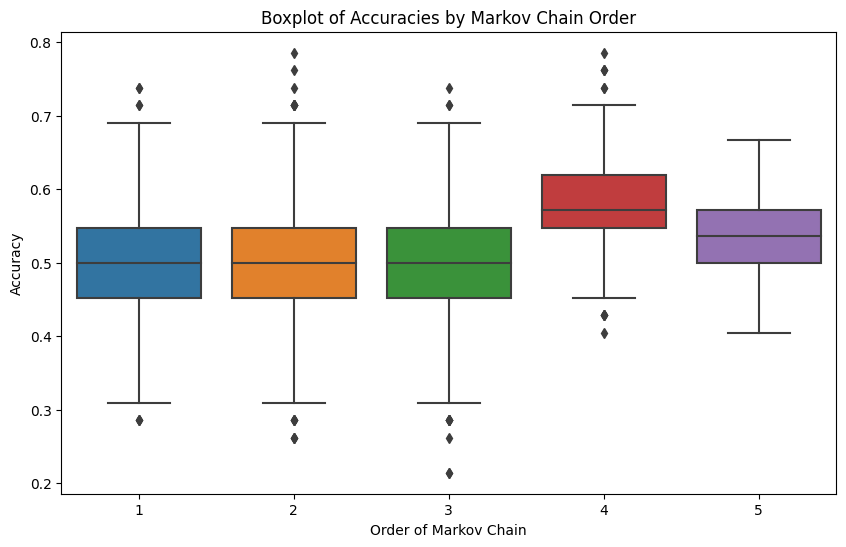

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean accuracy for each order
mean_accuracies = df_results.groupby('Order')['Accuracy'].mean()

print("Mean Accuracies by Order:")
print(mean_accuracies)

# Boxplot to visualize the spread of accuracies for each order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Order', y='Accuracy', data=df_results)
plt.title('Boxplot of Accuracies by Markov Chain Order')
plt.xlabel('Order of Markov Chain')
plt.ylabel('Accuracy')
plt.show()


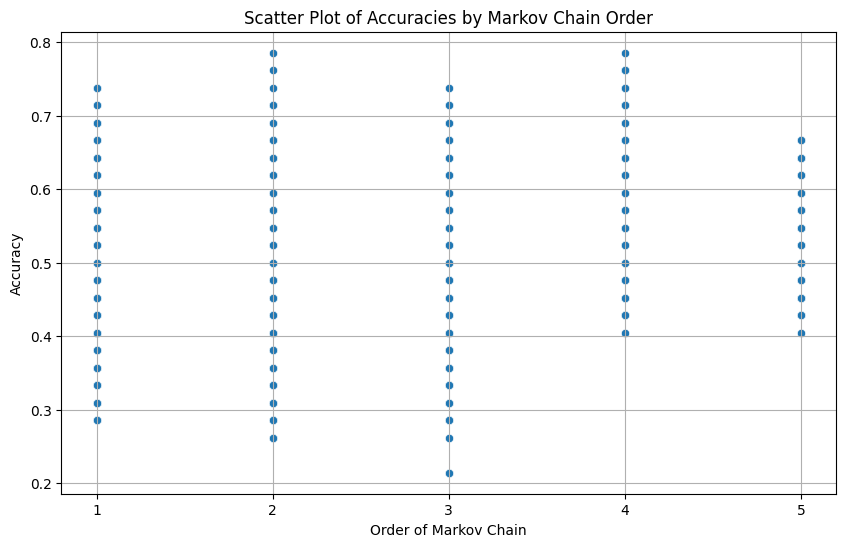

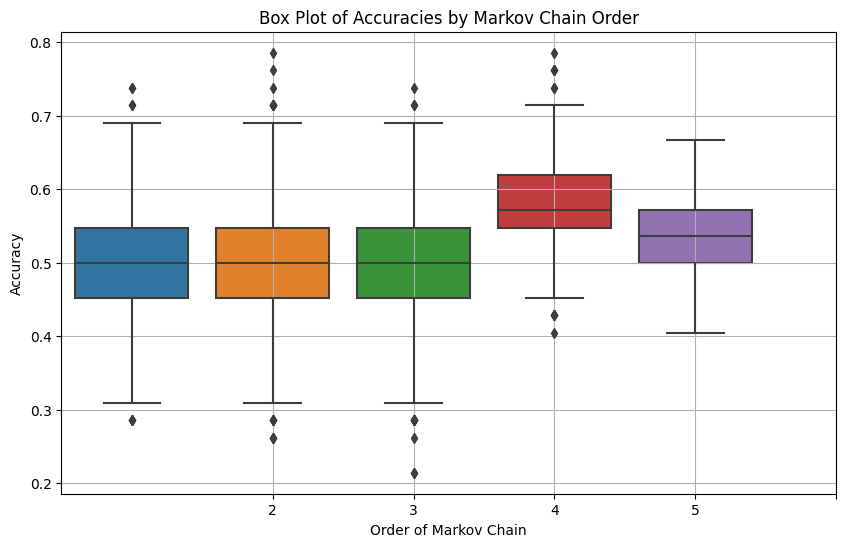

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Order', y='Accuracy', data=df_results)
plt.title('Scatter Plot of Accuracies by Markov Chain Order')
plt.xlabel('Order of Markov Chain')
plt.ylabel('Accuracy')
plt.xticks(range(1, max_order+1))  # Set x-ticks to display each order
plt.grid(True)  # Adding a grid for better readability of the plot
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Order', y='Accuracy', data=df_results)
plt.title('Box Plot of Accuracies by Markov Chain Order')
plt.xlabel('Order of Markov Chain')
plt.ylabel('Accuracy')
plt.xticks(range(1, max_order+1))  # Set x-ticks to display each order
plt.grid(True)  # Adding a grid for better readability of the plot
plt.show()



### Observations:
1. **Consistency:** The 2nd order Markov chain seems to have the most consistent accuracy with a smaller interquartile range (IQR). This suggests that for most simulations, it provides a relatively predictable level of accuracy.
  
2. **Highest Median Accuracy:** The 3rd order has a slightly higher median accuracy compared to the 2nd order, suggesting that on average, it might perform a bit better.

3. **Spread:** The 4th order has a wider spread and a few outliers, especially one on the higher side. This might suggest that, while it can sometimes give good results, its performance is more variable and less predictable.

4. **Declining Performance:** The 5th order shows a decline in the median accuracy, indicating diminishing returns as the order increases.

### Implications & Recommendations:

1. **Training Data Volume:** Higher-order Markov chains may require more extensive training data. Since they consider longer sequences, the chance of encountering unseen sequences in the test set increases. If your dataset isn't particularly large, this could explain the declining performance with higher orders. Therefore, gathering more data could be beneficial, especially for higher-order models.

2. **Training Data Nature:** The box plot shows variability across different orders, emphasizing the importance of understanding the underlying sequences. As previously mentioned, segmenting data based on certain criteria (home/away games, specific opponents, player availability) might offer insights into which sequences are more predictable and in what context.

3. **Optimal Order Selection:** Given the results, it might be worth focusing on the 2nd and 3rd orders. The 2nd order offers consistent results, and the 3rd order has a slightly better average accuracy. However, always consider the trade-offs: the 3rd order, while having a higher median, also has a slightly more extensive IQR than the 2nd order, indicating more variability in its results.

4. **Model Validation:** Before settling on a specific order, consider evaluating the models further on different subsets of the data, or using techniques like cross-validation, to ensure that the selected order generalizes well.

5. **Beyond Markov Chains:** Markov chains base predictions solely on historical sequences. Other factors, such as team compositions, player form, injuries, and more, are not considered. If the aim is to get the highest predictive accuracy, it might be worthwhile to consider more sophisticated models that can incorporate a wider range of influencing factors.

In summary, based on the box plot, while the 2nd and 3rd orders seem to be the most promising, there's always room to explore how different training data selections can influence the results. By understanding the nature of the data and the context better, you can make more informed decisions on model selection and training data optimization.

In [ ]:
def get_predictions(training_sequence, num_predictions, order, transition_matrix):
    # Ensure training_sequence is a list
    if isinstance(training_sequence, str):
        training_sequence = list(training_sequence)

    predictions = []
    for _ in range(num_predictions):
        current_sequence = training_sequence[-order:]  # Taking the last 'order' games from the training sequence
        next_state_probs = transition_matrix.get(tuple(current_sequence), {'W': 0.5, 'L': 0.5})
        predicted_state = pick_state('W', next_state_probs['W'], 'L', next_state_probs['L'])
        predictions.append(predicted_state)
        training_sequence.append(predicted_state)  # Add the predicted state to the sequence for the next prediction
    return predictions

# Forecast the next 29 games
forecasted_results = get_predictions(seq_train, 29, 3, transition_matrix_3rd_order)
print(forecasted_results)



['W', 'W', 'L', 'W', 'W', 'L', 'L', 'W', 'L', 'W', 'W', 'L', 'W', 'W', 'L', 'L', 'L', 'L', 'L', 'W', 'W', 'W', 'L', 'W', 'W', 'L', 'W', 'W', 'W']
